In [1]:
import itertools as it
import os

from iterpop import iterpop as ip
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
# prints metadata about notebook runtime
nbm.print_metadata()


context: ci
hostname: 231cdd910376
interpreter: 3.8.12 (default, Jan 15 2022, 18:39:47)  [GCC 7.5.0]
nbcellexec: 2
nbname: reconstructed-tree-phylometrics
nbpath: /opt/hstrat-evolutionary-inference/binder/reconstructed-tree-phylometrics.ipynb
revision: null
session: 9ea76f39-90f9-423c-a644-3c40ea491db7
timestamp: 2023-03-13T12:11:12Z00:00


IPython==7.16.1
keyname==0.5.2
yaml==6.0
iterpop==0.4.1
matplotlib==3.5.3
nbmetalog==0.2.6
numpy==1.21.6
pandas==1.3.5
scipy==1.7.3
seaborn==0.12.2
teeplot==0.2.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.0.3
json==2.0.9
six==1.16.0
ipykernel==5.5.3


In [3]:
df = pd.read_csv("https://osf.io/5trmg/download")
dfdigest = np.bitwise_xor.reduce(
    pd.util.hash_pandas_object(df),
)
print("{:x}".format(dfdigest))
df


40f23b7946d11896


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2.677385e+06,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2.726867e+06,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2.835695e+06,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2.499463e+06,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2.477275e+06,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104994,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,24.562416,24.562416,1,3305,99.163609,3.242650e+04,282.320163,30.0,0.01,naive
104995,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,16,...,17.300466,17.300466,0,2923,1893.146789,6.190590e+05,250803.885040,100.0,0.01,rollback
104996,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,1,...,88.702783,88.702783,1,717008,5.744125,1.882235e+05,6.163179,100.0,1.00,rollback
104997,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,10,...,25.685331,25.685331,0,516453,28.659882,9.391270e+05,116.954707,3.0,1.00,naive


In [4]:
# phylometrics whittled down to descriptive, non-redundant set
phylometrics = [
    #     'diversity',
    "colless_like_index",
    #     'average_depth',
    #     'average_origin_time',
    #     'average_origin_time_normalized',
    #     'max_depth',
    "mean_pairwise_distance",
    #     'mean_pairwise_distance_branch_only',
    #     'num_active',
    "num_ancestors",
    #     'num_outside',
    #     'num_roots',
    #     'num_taxa',
    #     'phylogenetic_diversity',
    #     'sum_pairwise_distance',
    #     'sum_pairwise_distance_branch_only',
    #     'total_orgs',
    #     'tree_size',
    #     'variance_pairwise_distance',
    #     'variance_pairwise_distance_branch_only',
    #     'mrca_depth',
    #     'sackin_index',
    "mean_evolutionary_distinctiveness",
    #     'sum_evolutionary_distinctiveness',
    #     'variance_evolutionary_distinctiveness',
]


In [5]:
methodological_variables = [
    "resolution",
]


In [6]:
evolutionary_variables = [
    "num_islands",
    "num_niches",
    "tournament_size",
    "p_niche_invasion",
]


In [7]:
sensitivity_analysis_variables = [
    "epoch",
    "mut_distn",
]


In [8]:
fixed_variables = [
    "num_generations",  # homogeneous (num generations per epoch)
    "p_island_migration",  # homogeneous
    "population_size",  # homogeneous
    "subsampling-fraction",  # only use 1.0
    "trie-postprocess",  # just use naive postprocessing for now
]


In [9]:
# ensure fixed variables
df = df[
    (df["p_island_migration"] == 0.01)
    & ((df["subsampling-fraction"] == 1.0) | df["subsampling-fraction"].isna())
    & ((df["trie-postprocess"] == "naive") | df["trie-postprocess"].isna())
].copy()

for fixed_variable in fixed_variables:
    assert len(df[fixed_variable].dropna().unique()) == 1

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2677385.0,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2726867.0,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2835695.0,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2499463.0,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2477275.0,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104955,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,25,...,86.927779,86.927779,1,724151,6.498184,212932.5,6.463885,100.0,1.0,naive
104957,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,19,...,41.519441,41.519441,1,564013,4.646164,152245.5,2.874790,30.0,1.0,naive
104969,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,17,...,72.132664,72.132664,1,685644,5.576447,182729.0,3.720116,30.0,1.0,naive
104970,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,3,...,29.663459,29.663459,0,527010,29.281845,959507.5,121.981043,3.0,1.0,naive


In [10]:
# exclude extraneous variable values
df = df[(df["a"] != "consolidated-phylogeny")].copy()

df


,a,epoch,mut_distn,num_generations,num_islands,num_niches,p_island_migration,p_niche_invasion,population_size,replicate,...,variance_pairwise_distance,variance_pairwise_distance_branch_only,mrca_depth,sackin_index,mean_evolutionary_distinctiveness,sum_evolutionary_distinctiveness,variance_evolutionary_distinctiveness,resolution,subsampling-fraction,trie-postprocess
0,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,4,...,27.305316,27.305316,1,570110,81.707306,2677385.0,1030.406615,NaN,NaN,NaN
1,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,41,...,26.027820,26.027820,0,548025,83.217377,2726867.0,1170.361609,NaN,NaN,NaN
2,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,47,...,27.705938,27.705938,0,559117,86.538544,2835695.0,1284.142442,NaN,NaN,NaN
3,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,15,...,28.664163,28.664163,1,583153,76.277557,2499463.0,1545.456043,NaN,NaN,NaN
4,collapsed-phylogeny,7,np.random.standard_normal,32768,1024,4,0.01,3.051758e-06,32768,19,...,27.416625,27.416625,0,583519,75.600433,2477275.0,1027.817652,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104955,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,25,...,86.927779,86.927779,1,724151,6.498184,212932.5,6.463885,100.0,1.0,naive
104957,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,19,...,41.519441,41.519441,1,564013,4.646164,152245.5,2.874790,30.0,1.0,naive
104969,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,17,...,72.132664,72.132664,1,685644,5.576447,182729.0,3.720116,30.0,1.0,naive
104970,reconstructed-tree,2,np.random.standard_normal,32768,1,4,0.01,3.051758e-08,32768,3,...,29.663459,29.663459,0,527010,29.281845,959507.5,121.981043,3.0,1.0,naive


In [11]:
df["num_niches"].unique()


array([4, 8, 1])

In [12]:
df["num_islands"].unique()


array([1024,    1])

In [13]:
df["tournament_size"].unique()


array([2, 4, 1])

In [14]:
df["a"].unique()


array(['collapsed-phylogeny', 'reconstructed-tree'], dtype=object)

In [15]:
df["regime"] = df.apply(
    lambda row: {
        (1, 1, 2, 3.0517578125e-08): "plain",
        (1, 1, 1, 3.0517578125e-08): "weak selection",
        (1, 1, 4, 3.0517578125e-08): "strong selection",
        (1, 4, 2, 3.0517578125e-06): "weak 4 niche ecology",
        (1, 4, 2, 3.0517578125e-08): "4 niche ecology",
        (1, 8, 2, 3.0517578125e-08): "8 niche ecology",
        (1024, 1, 2, 3.0517578125e-08): "spatial structure",
    }.get(
        tuple(
            row[
                [
                    "num_islands",
                    "num_niches",
                    "tournament_size",
                    "p_niche_invasion",
                ]
            ]
        ),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["regime"]).copy()
df["regime"].unique()


array(['weak 4 niche ecology', '8 niche ecology', 'spatial structure',
       '4 niche ecology', 'weak selection', 'strong selection', 'plain'],
      dtype=object)

In [16]:
df[df["a"] == "collapsed-phylogeny"]["regime"].unique()


array(['weak 4 niche ecology', '4 niche ecology', 'weak selection',
       'plain', 'strong selection', 'spatial structure',
       '8 niche ecology'], dtype=object)

In [17]:
df["quality"] = df.apply(
    lambda row: {
        ("reconstructed-tree", 3.0): "33% resolution",
        ("reconstructed-tree", 10.0): "10% resolution",
        ("reconstructed-tree", 30.0): "3% resolution",
        ("reconstructed-tree", 100.0): "1% resolution",
        ("collapsed-phylogeny", 0): "perfect resolution",
    }.get(
        tuple(row[["a", "resolution"]].fillna(0)),
        np.nan,  # default
    ),
    axis="columns",
)
df = df.dropna(axis="index", subset=["quality"]).copy()
df["quality"].unique()


array(['perfect resolution', '10% resolution', '33% resolution',
       '3% resolution', '1% resolution'], dtype=object)

# Phylometrics by Regime, Reconstructed Data


In [18]:
melted_df = df.melt(
    id_vars=evolutionary_variables
    + methodological_variables
    + sensitivity_analysis_variables
    + ["regime", "a", "quality"],
    value_vars=phylometrics,
)
melted_df["phylometric"] = melted_df["variable"]
melted_df


,num_islands,num_niches,tournament_size,p_niche_invasion,resolution,epoch,mut_distn,regime,a,quality,variable,value,phylometric
0,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,346237.149255,colless_like_index
1,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,393531.329296,colless_like_index
2,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,358279.386159,colless_like_index
3,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,435516.244222,colless_like_index
4,1,4,2,3.051758e-06,NaN,7,np.random.standard_normal,weak 4 niche ecology,collapsed-phylogeny,perfect resolution,colless_like_index,378408.625158,colless_like_index
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,1,4,2,3.051758e-08,3.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,33% resolution,mean_evolutionary_distinctiveness,4.854187,mean_evolutionary_distinctiveness
41996,1,4,2,3.051758e-08,100.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,1% resolution,mean_evolutionary_distinctiveness,4.748322,mean_evolutionary_distinctiveness
41997,1,4,2,3.051758e-08,30.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,3% resolution,mean_evolutionary_distinctiveness,5.063843,mean_evolutionary_distinctiveness
41998,1,4,2,3.051758e-08,100.0,2,np.random.standard_normal,4 niche ecology,reconstructed-tree,1% resolution,mean_evolutionary_distinctiveness,6.498184,mean_evolutionary_distinctiveness


teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=0+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=0+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=2+mut_distn=np.random.exponential+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.pdf
teeplots/col=phylometric+epoch=2+mut_distn=np.random.standard_normal+row=regime+viz=barplot+x=value+y=quality+ext=.png
teeplots/col=phylometric+epoch=7+mut_distn=np.random.exponential

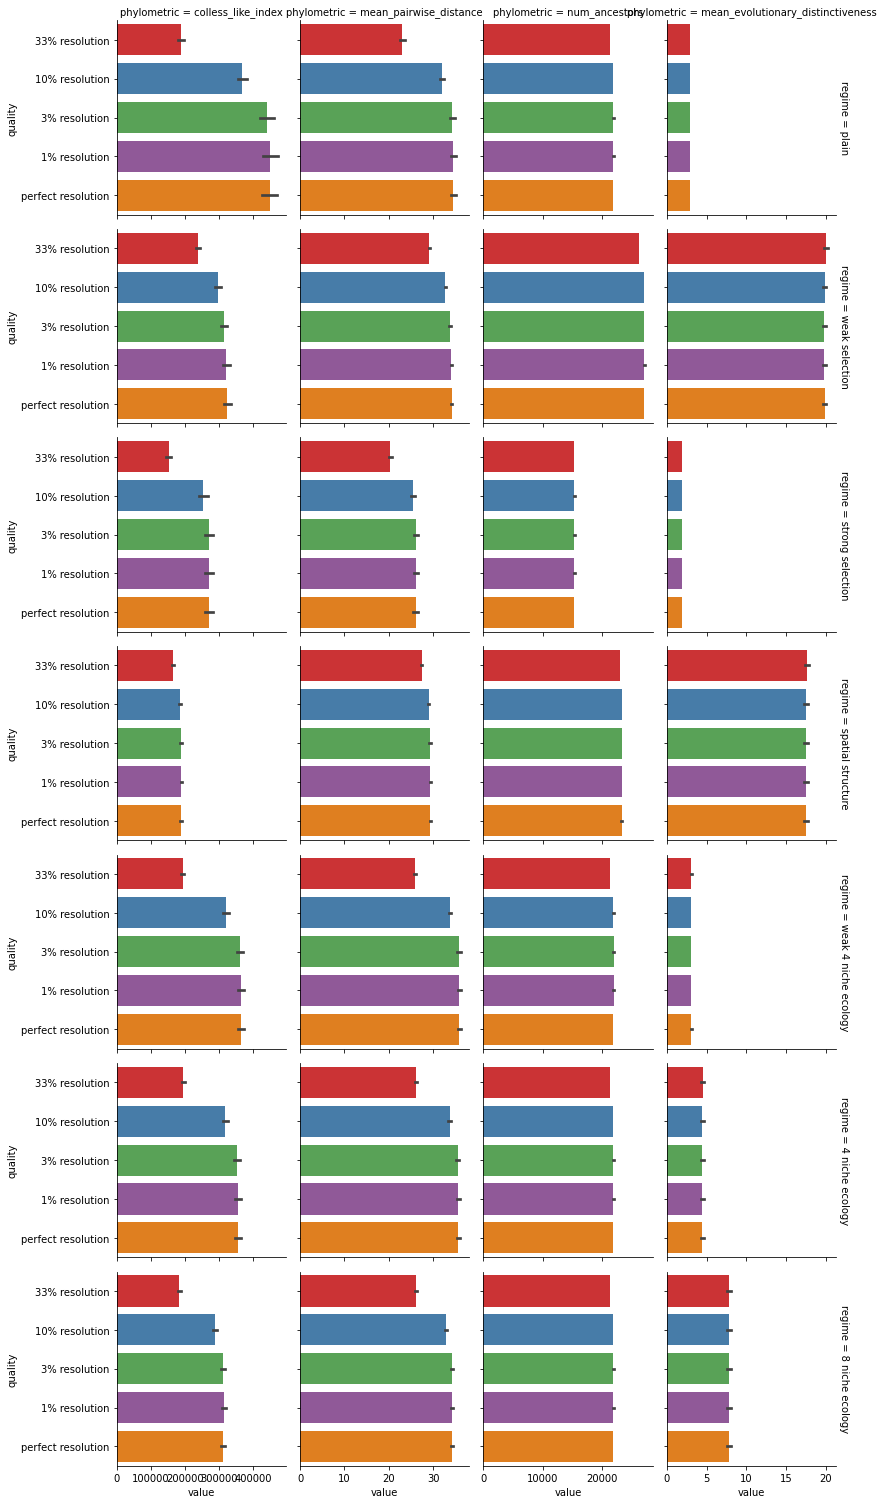

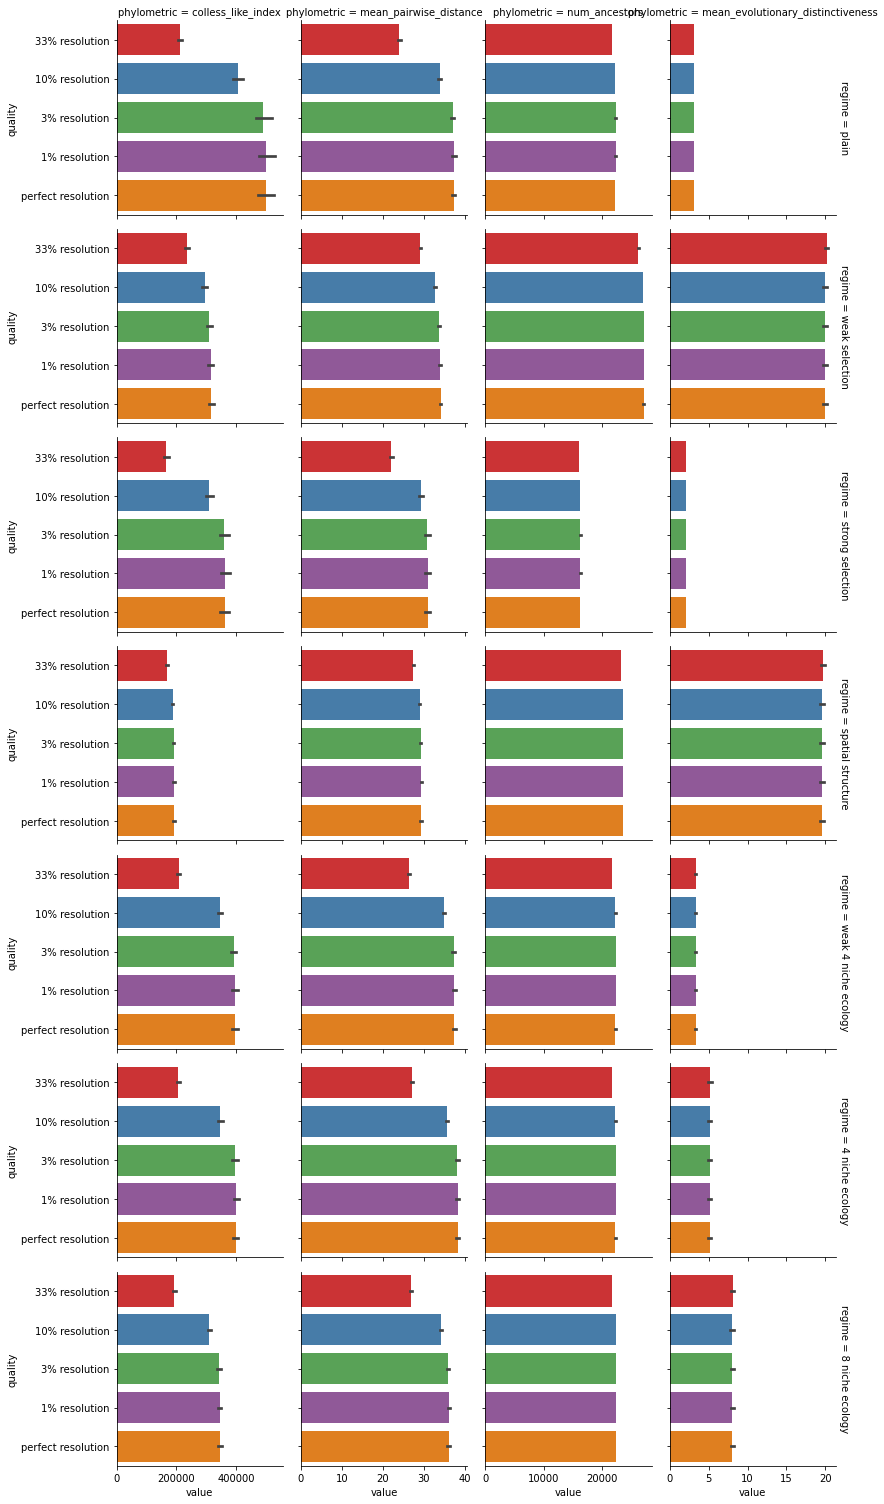

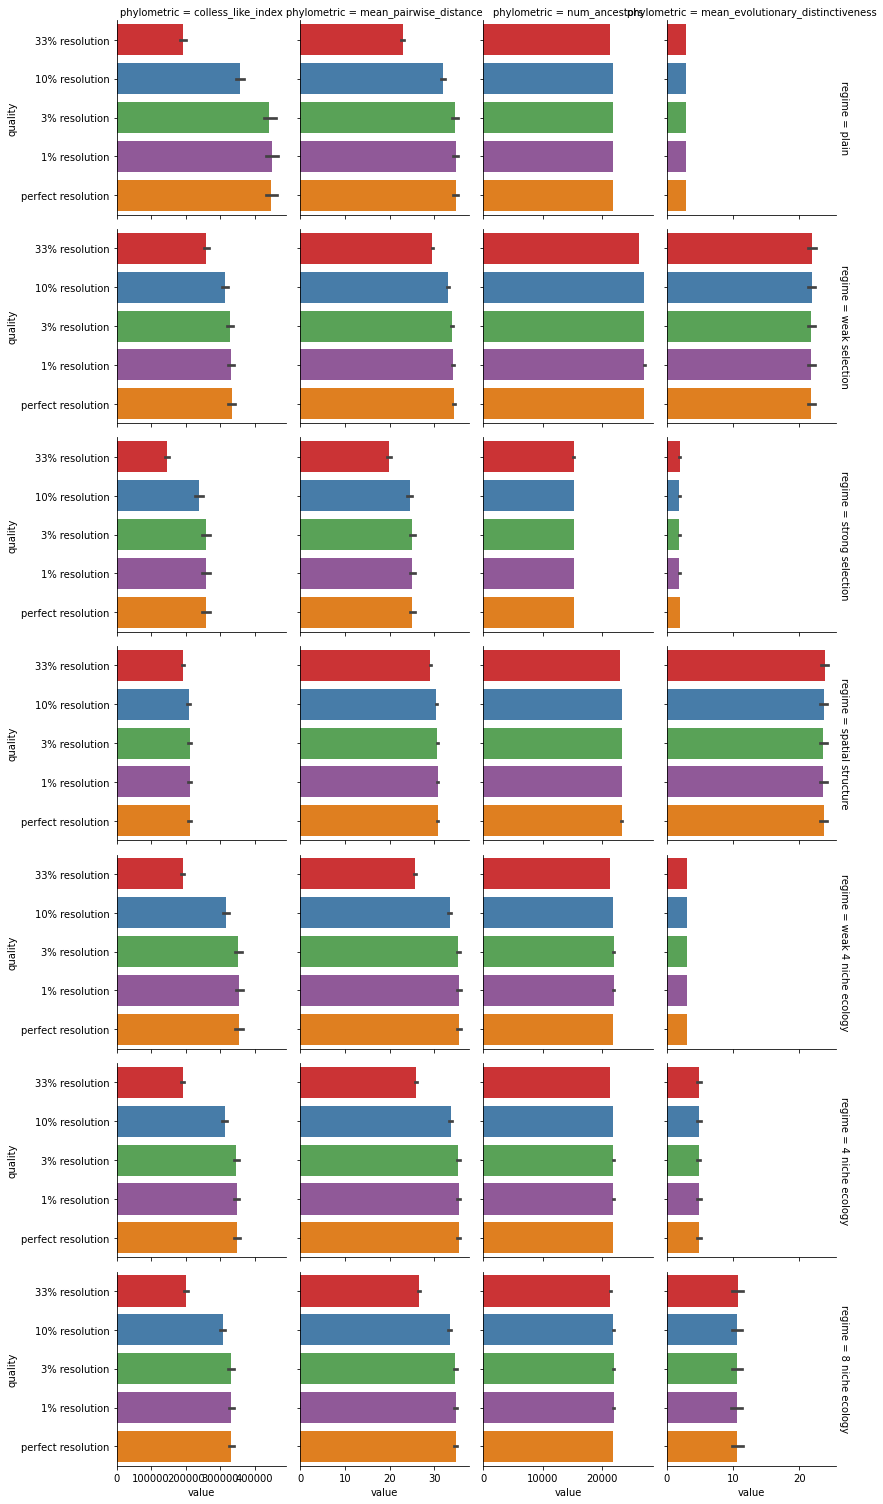

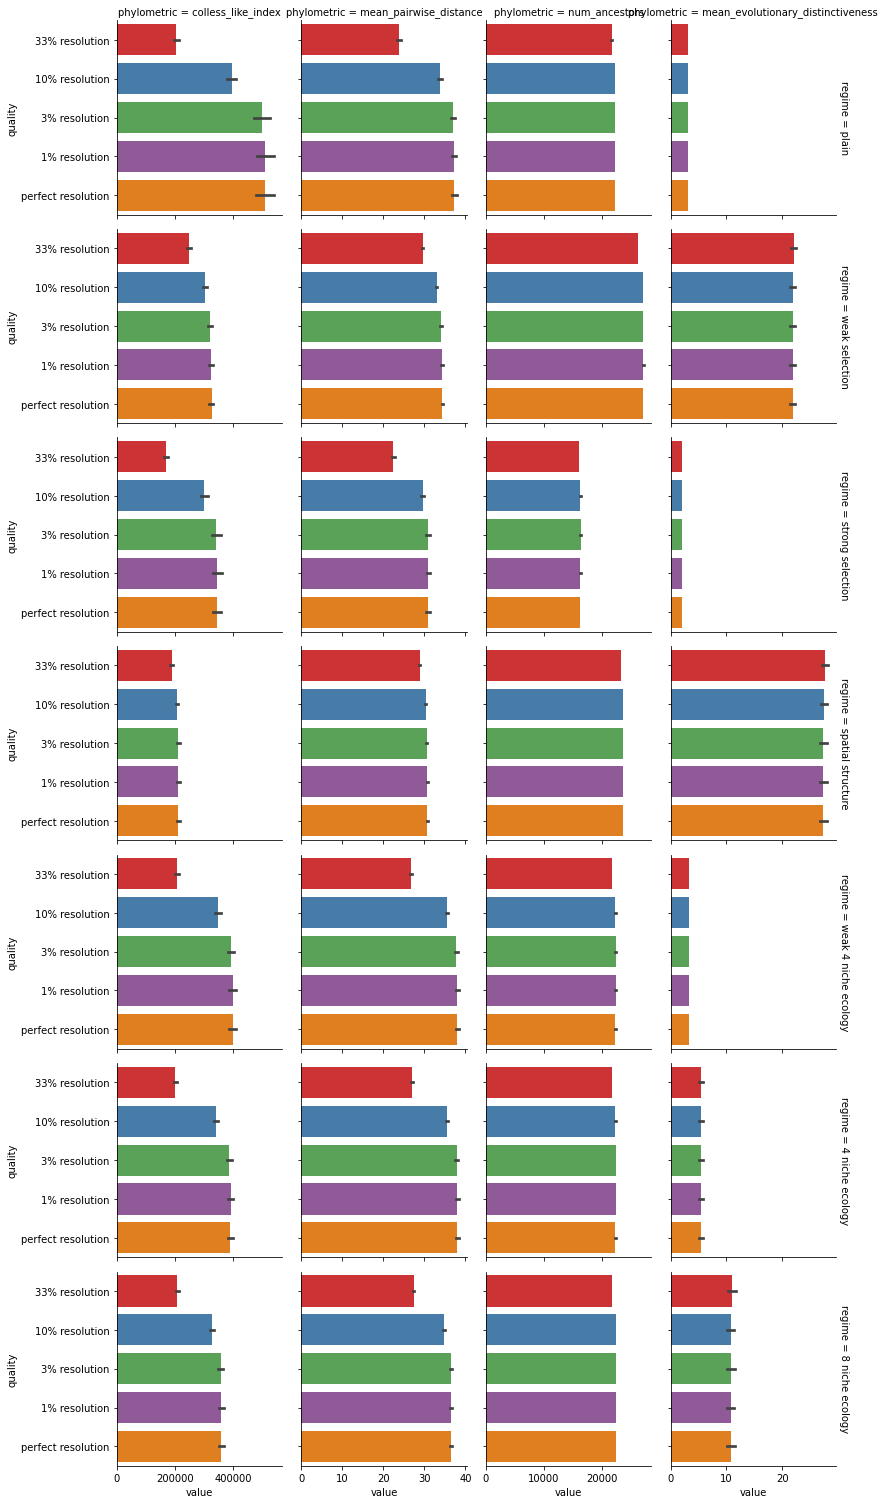

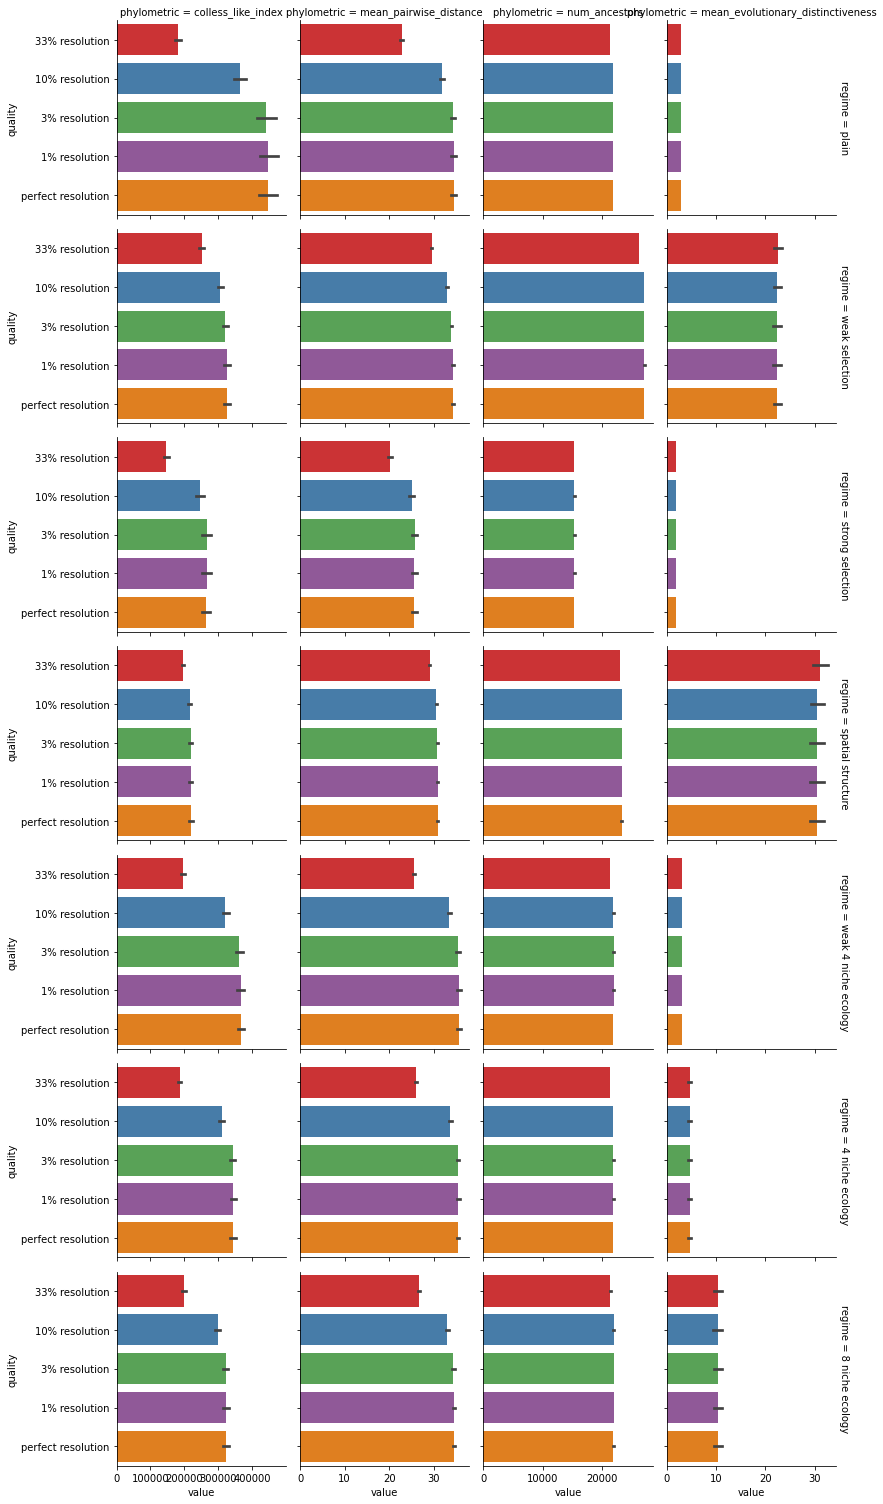

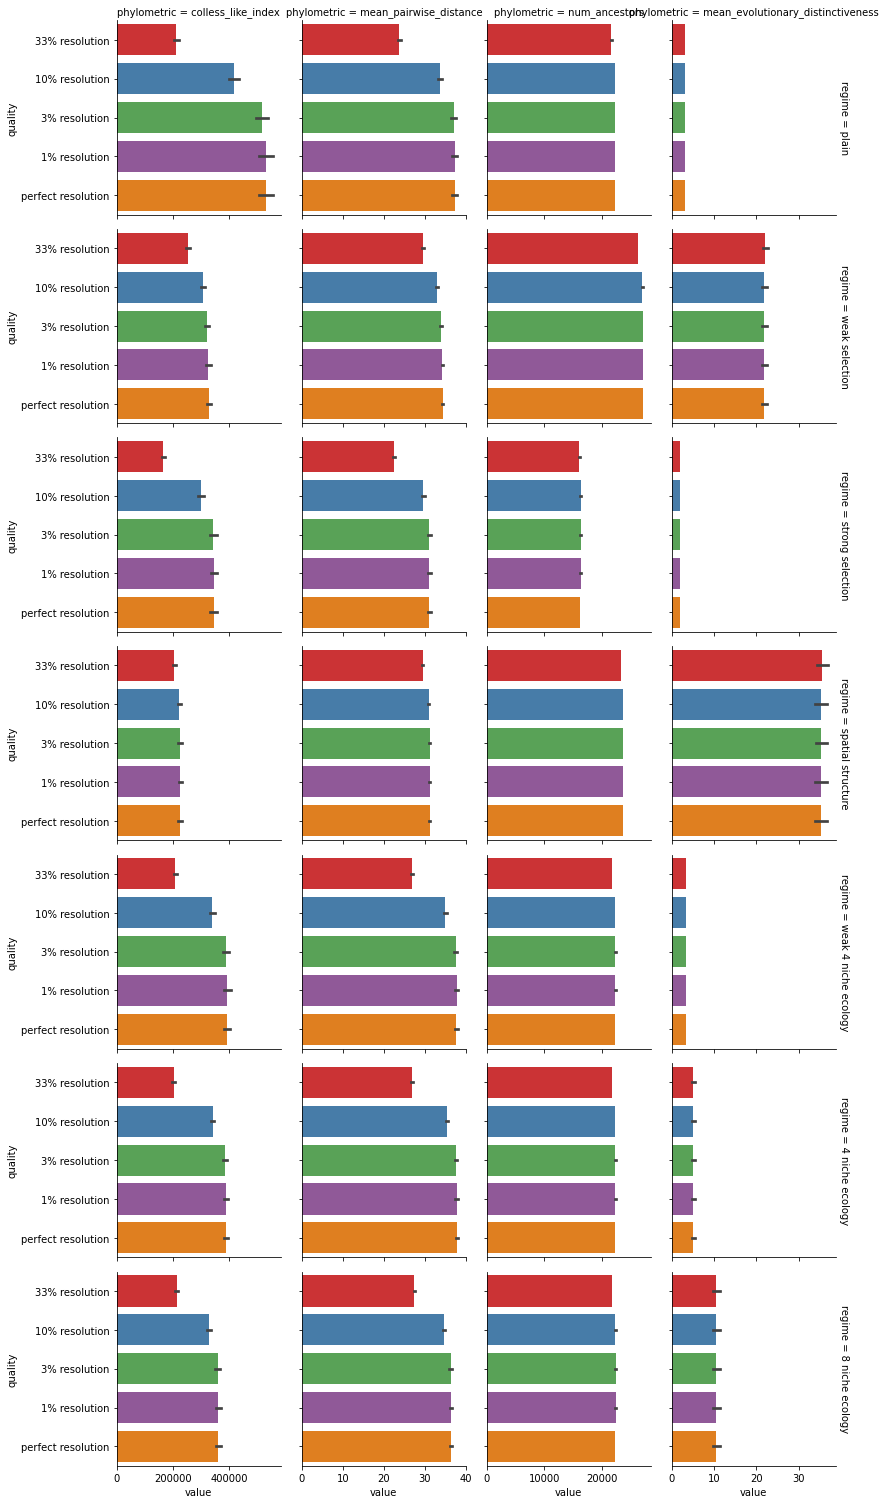

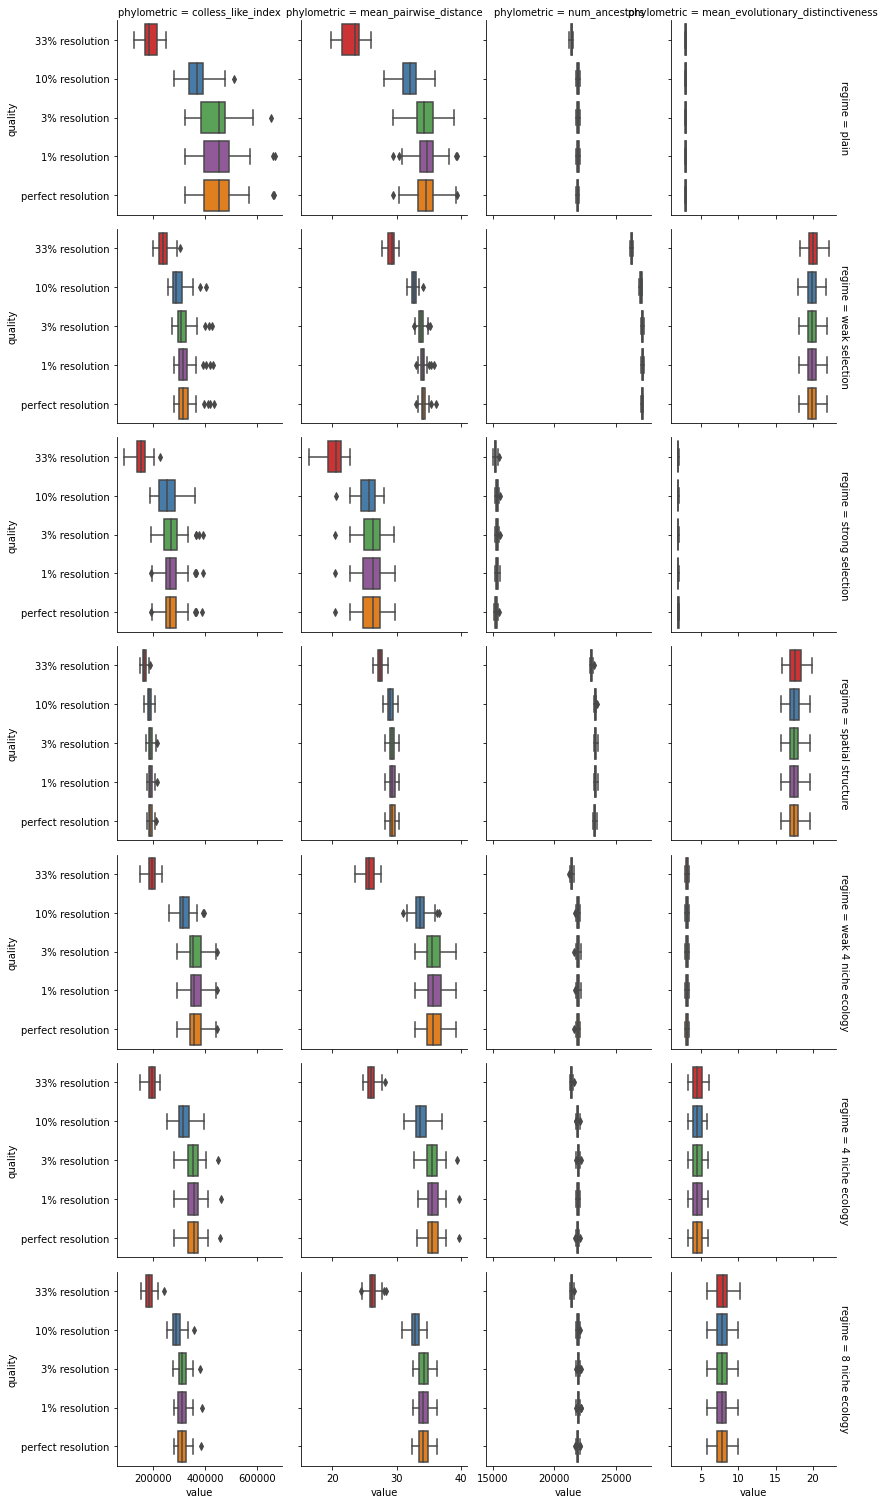

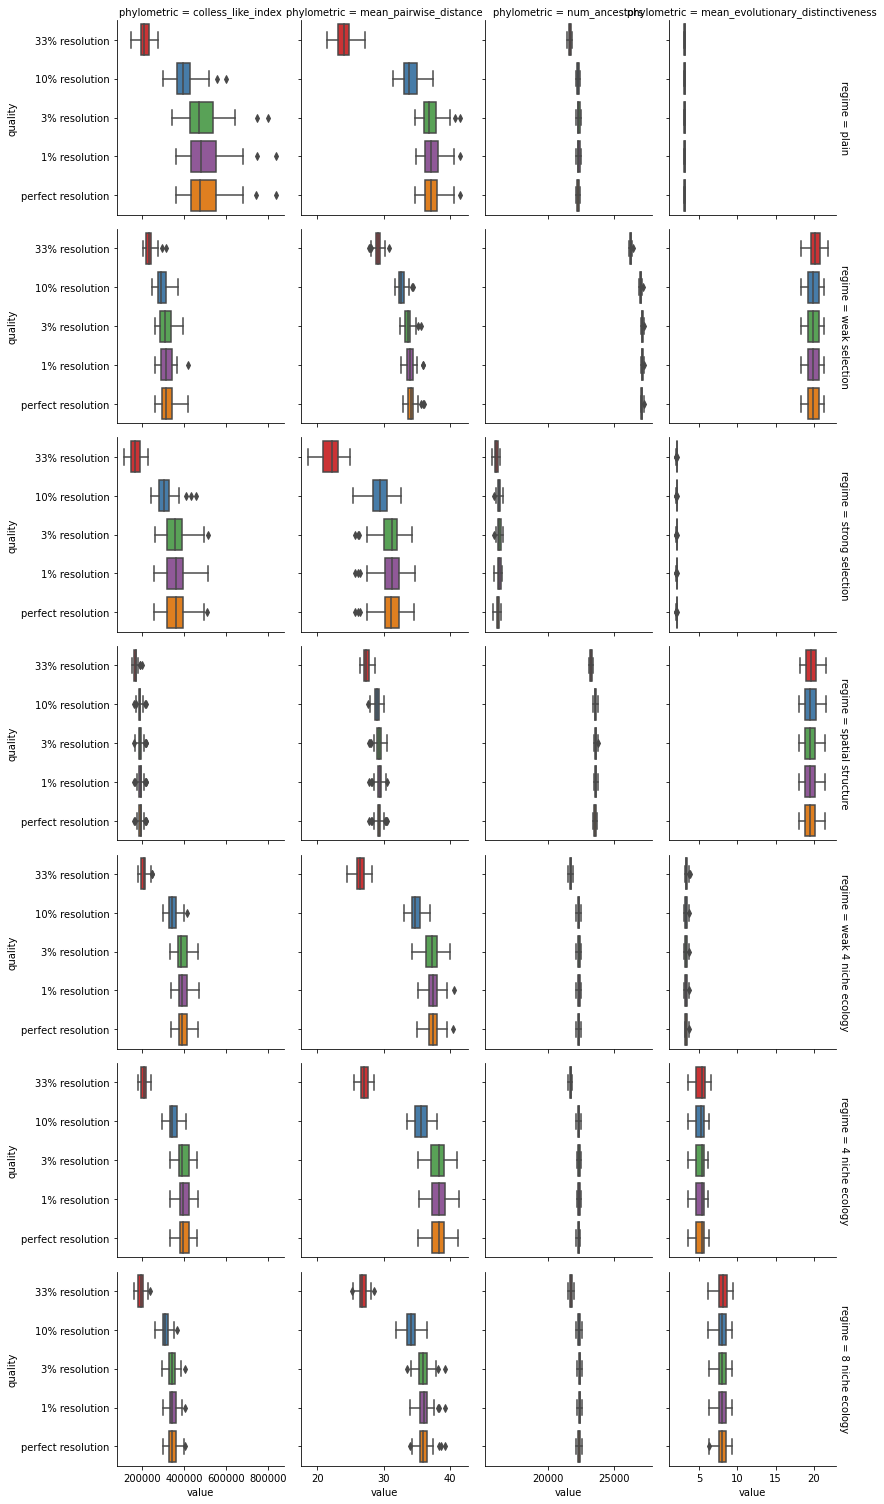

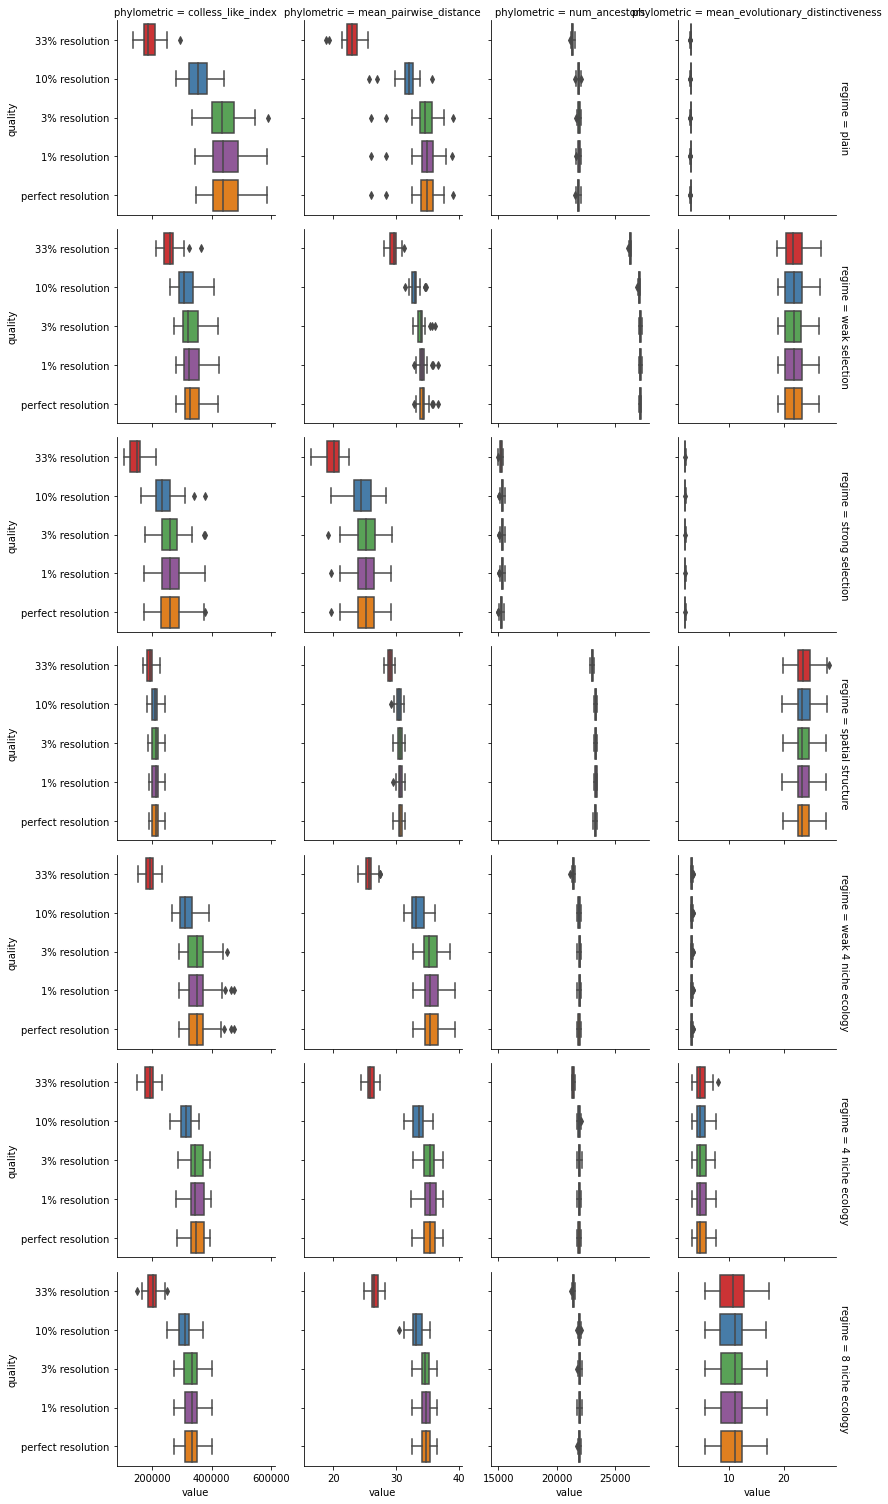

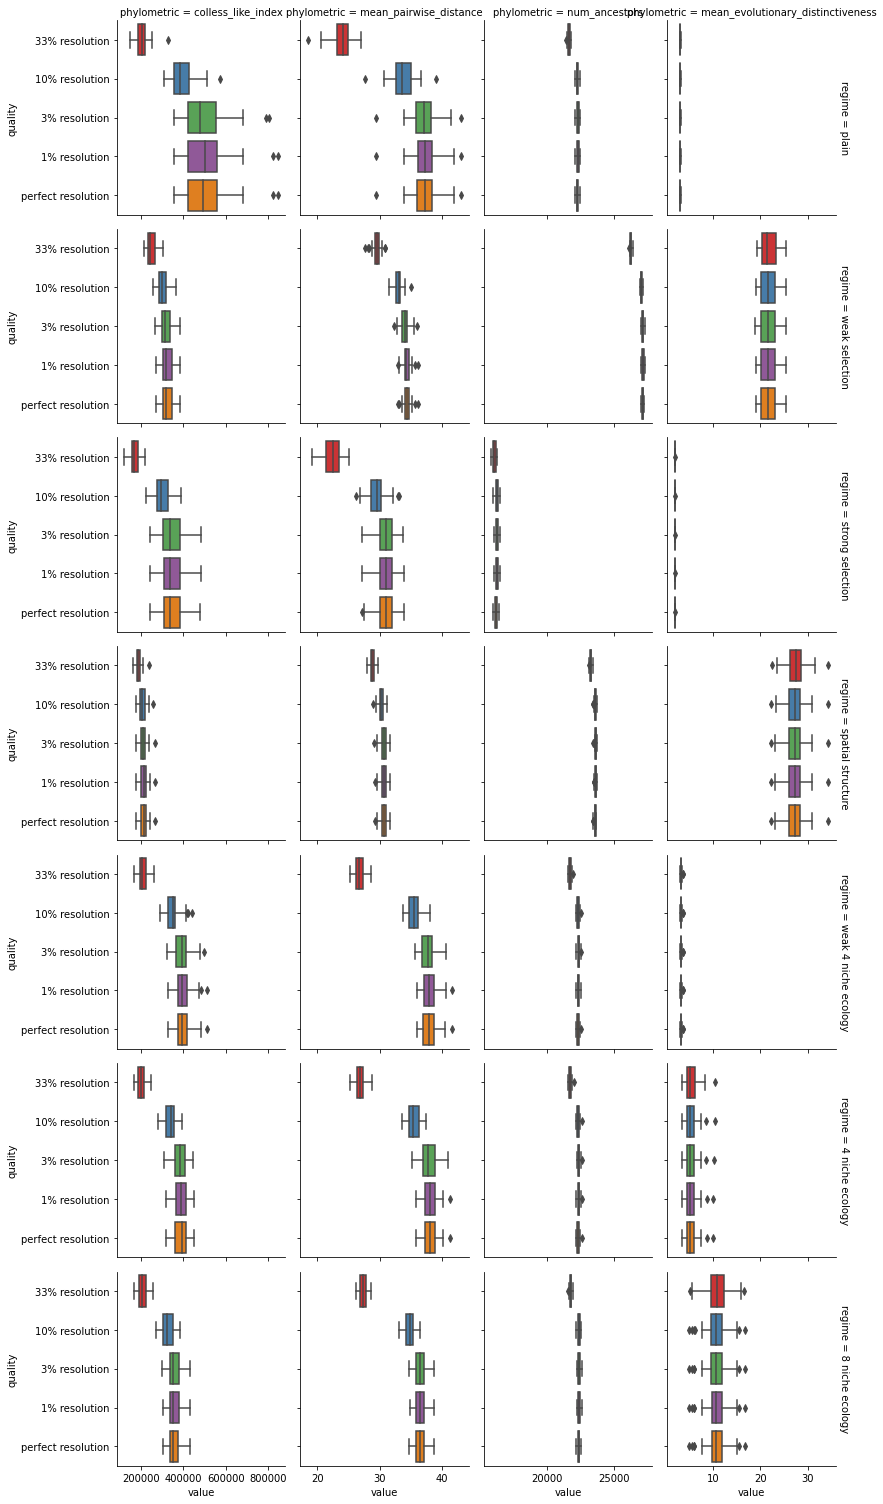

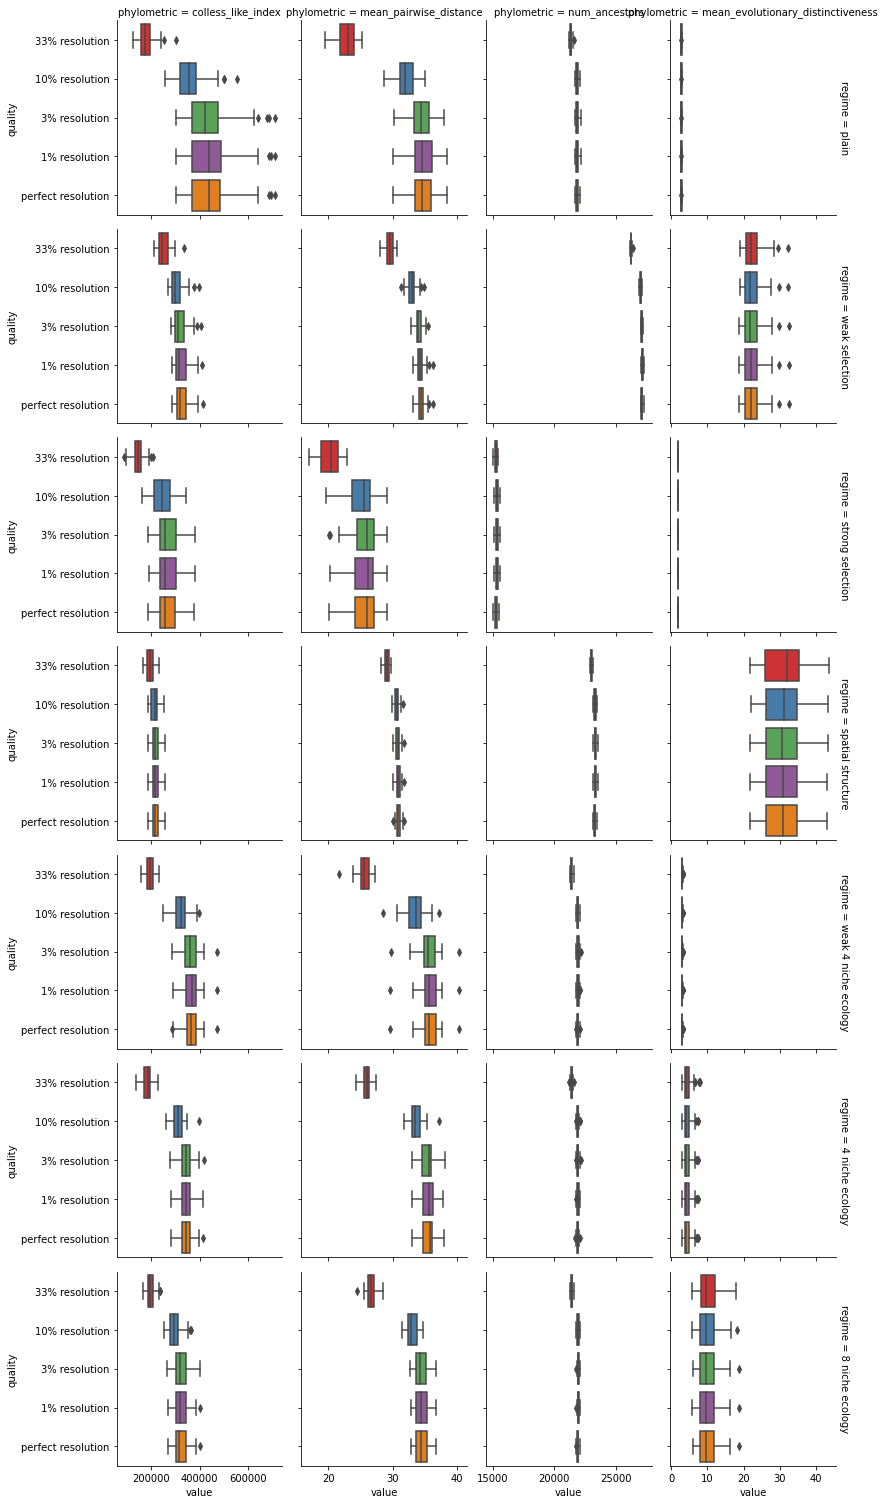

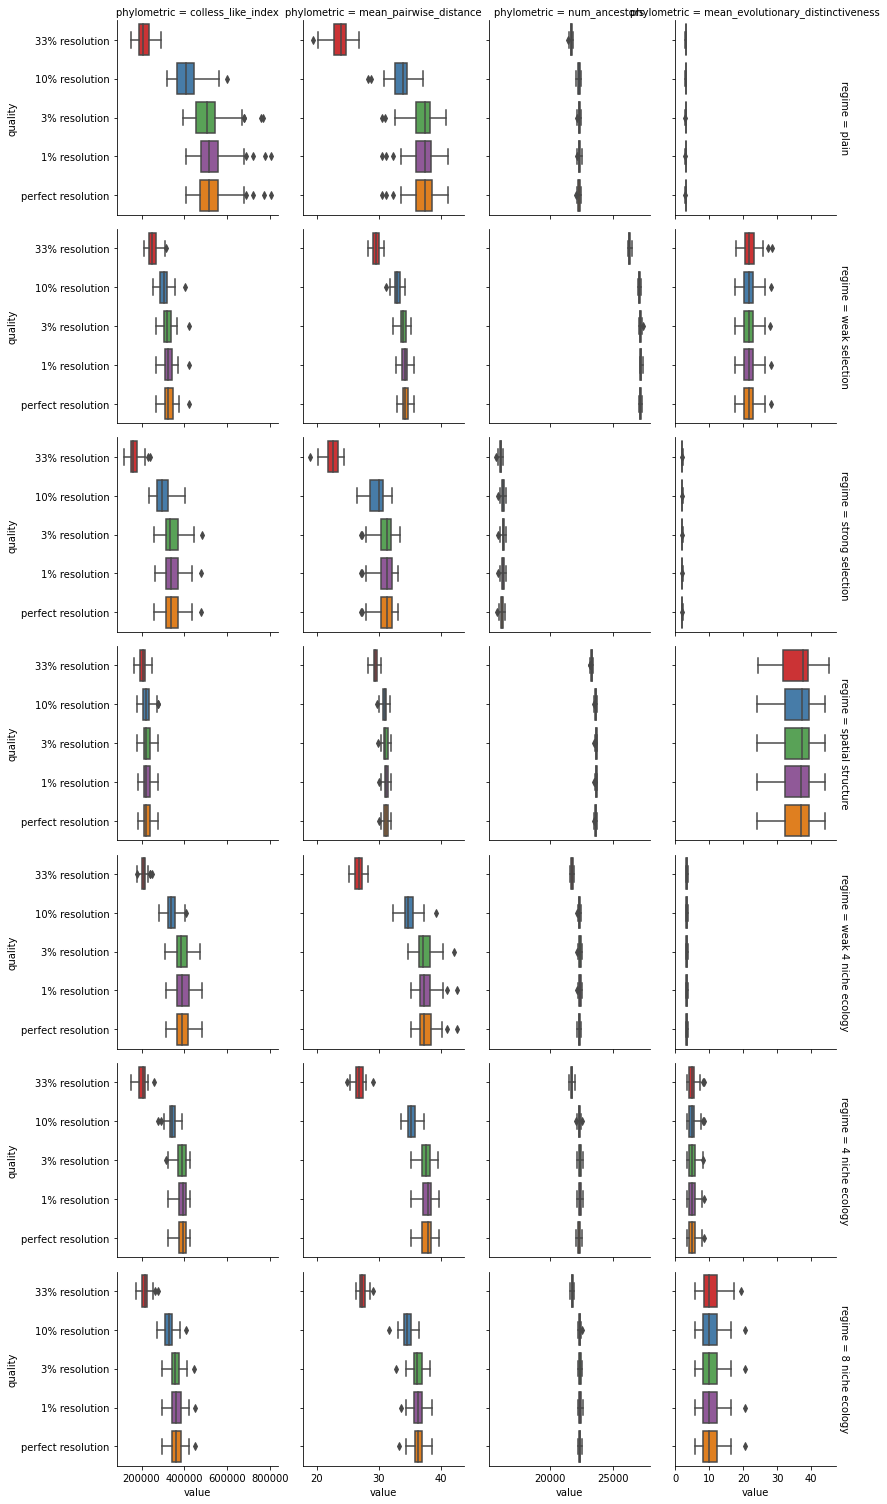

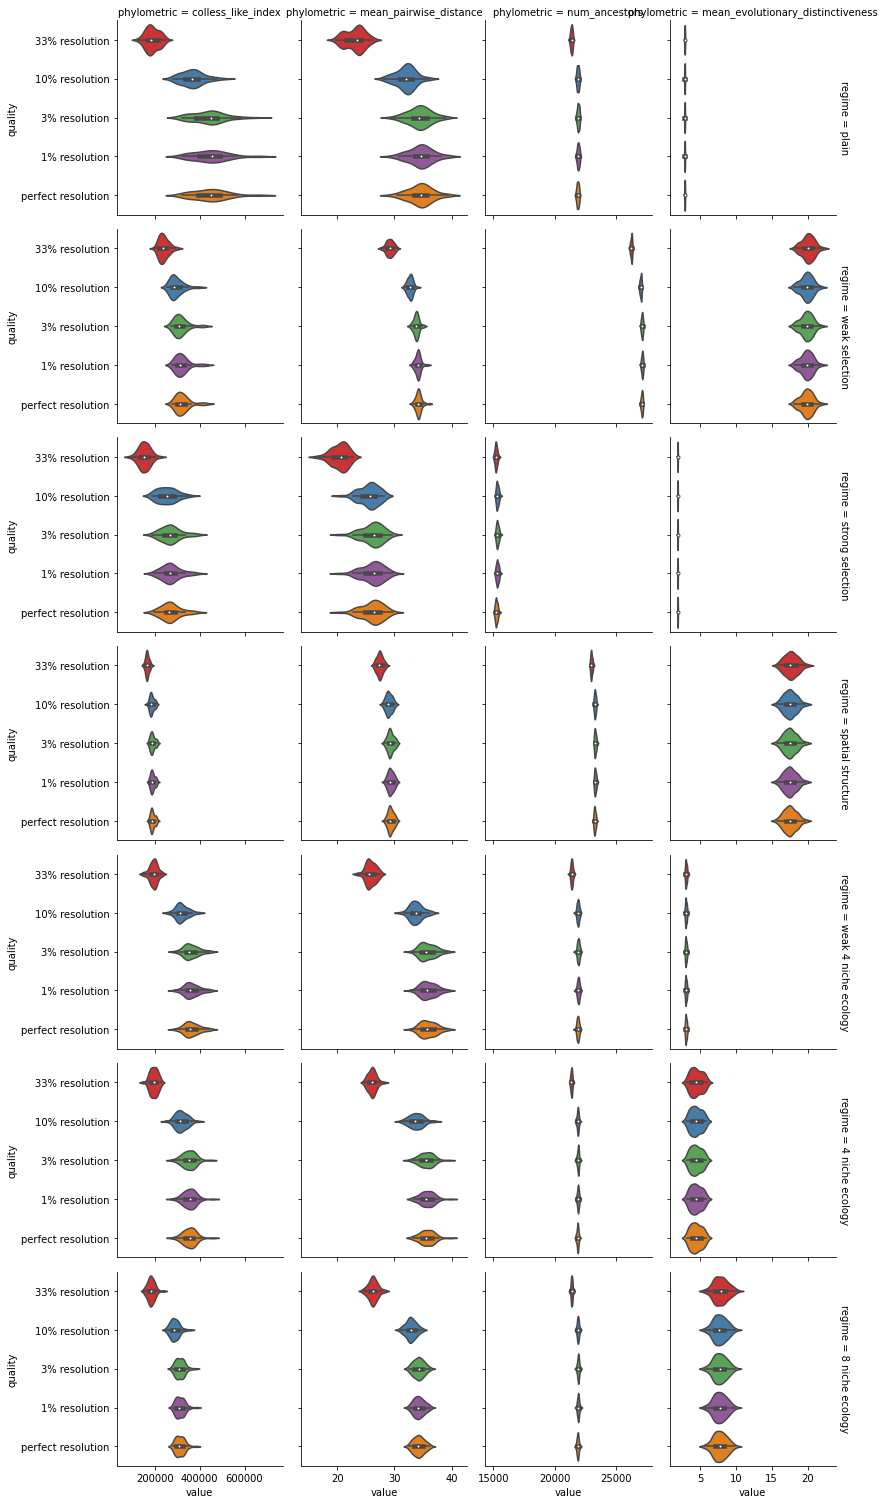

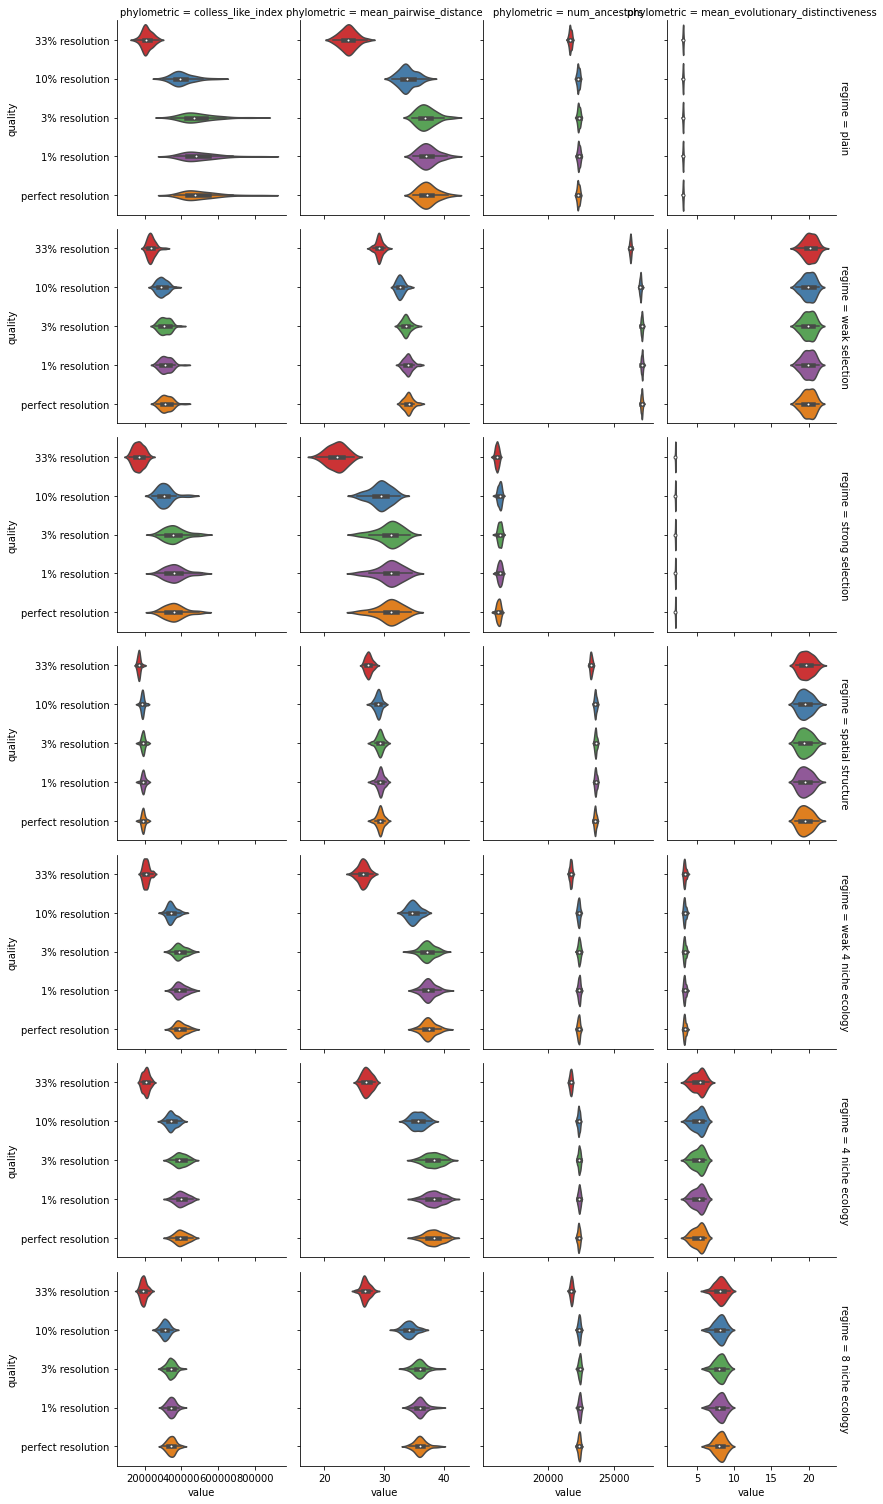

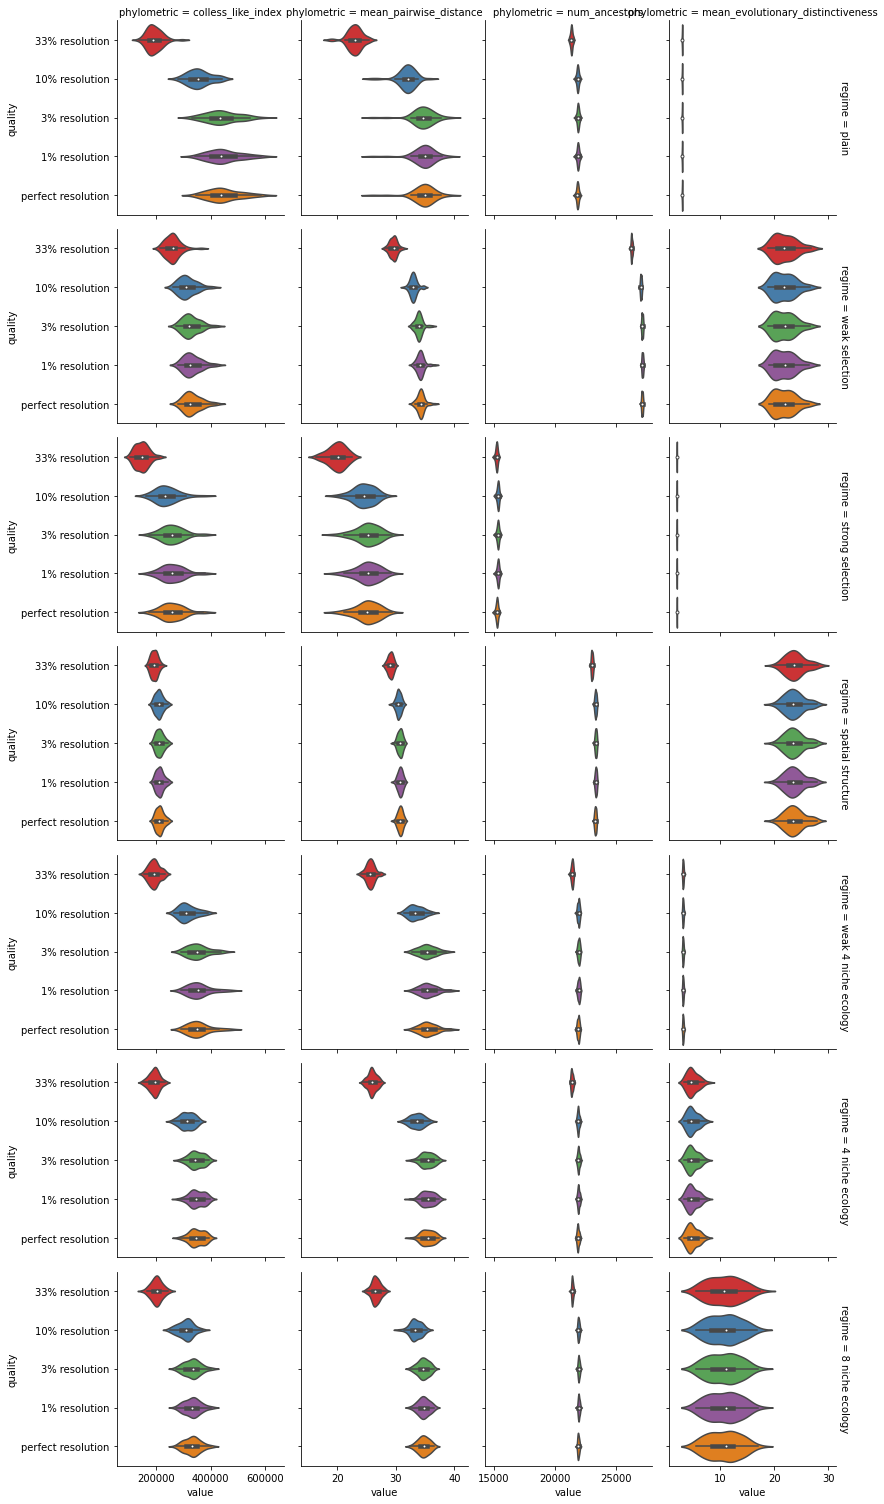

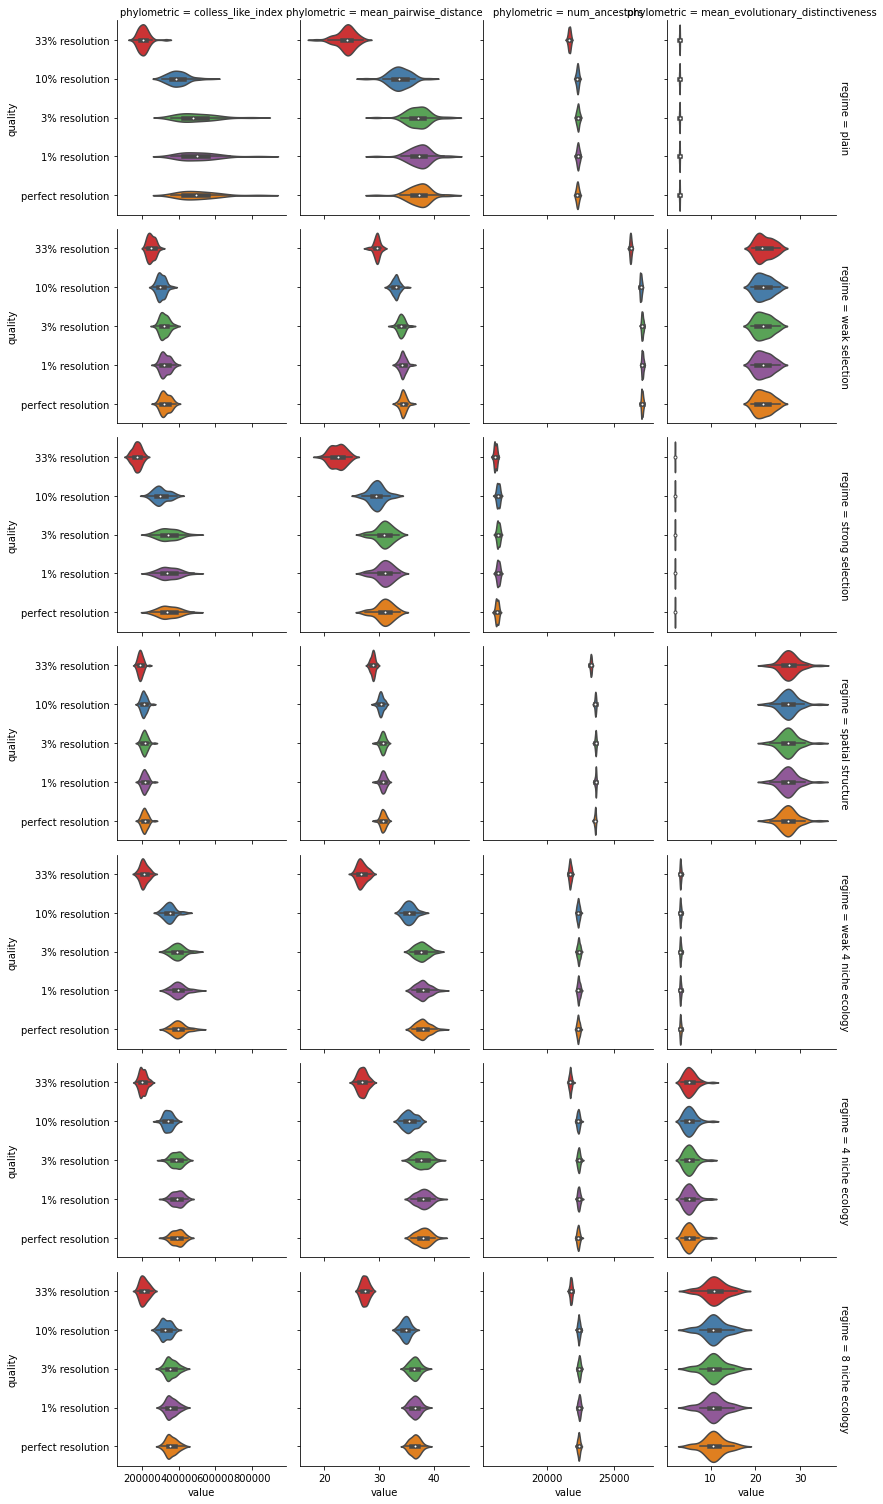

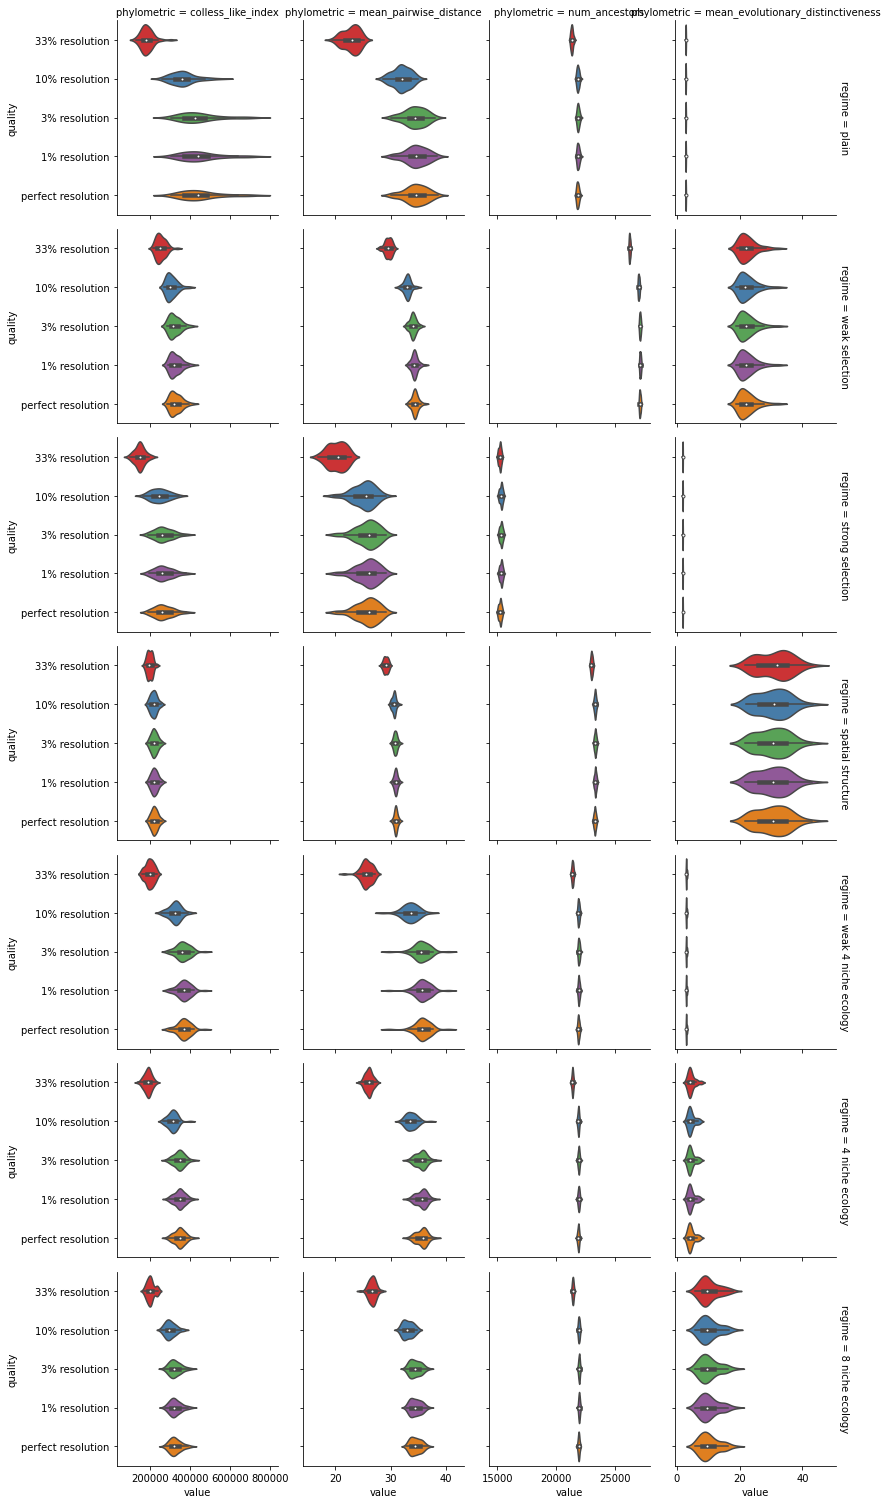

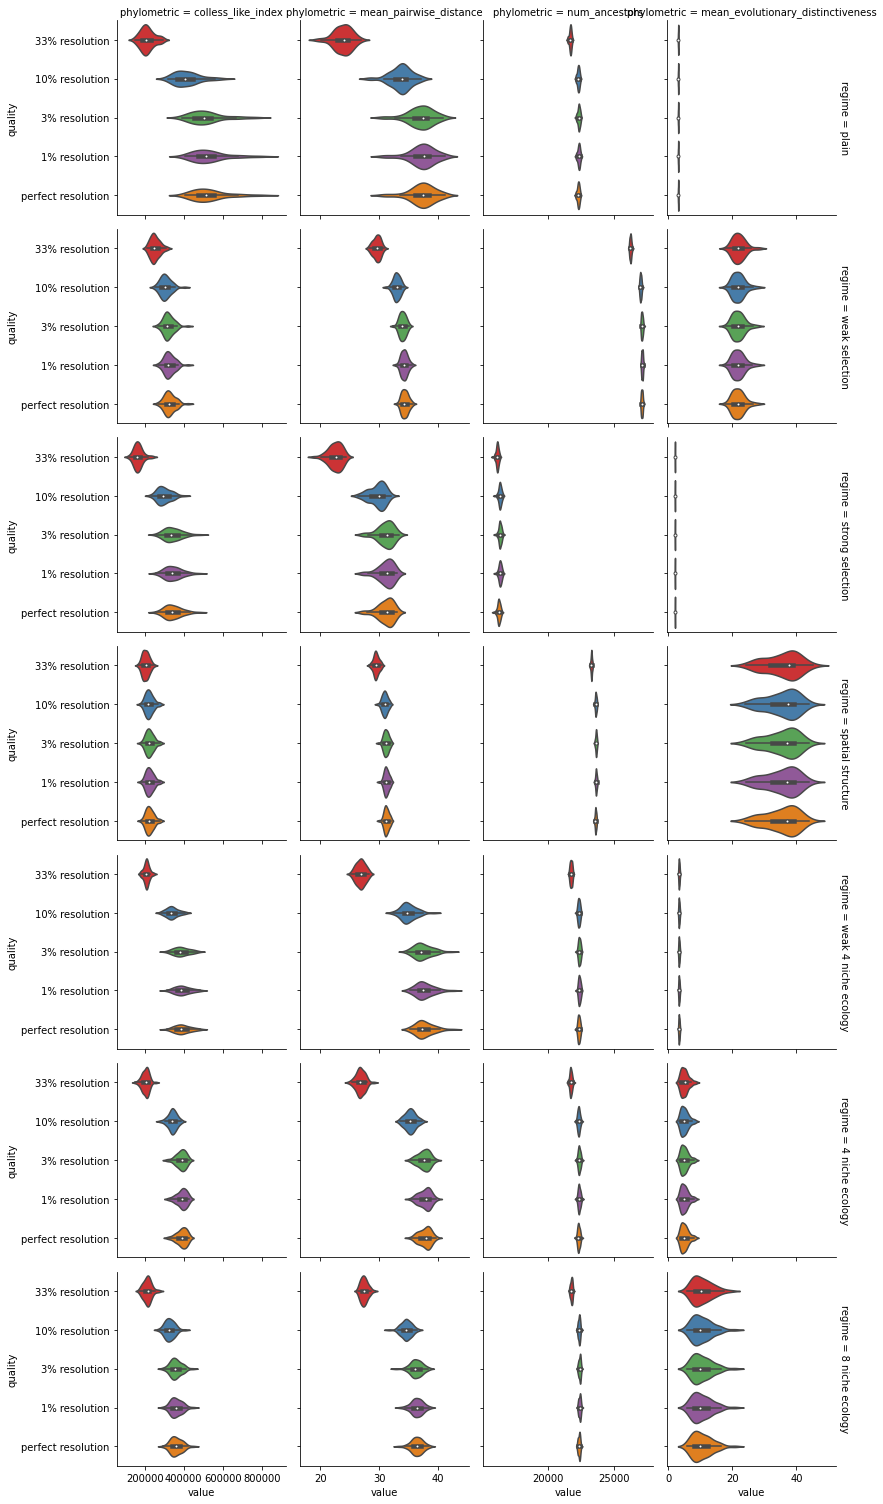

In [19]:
def make_do_plot(plotter):
    def do_plot(data, col, row, x, y):
        g = sns.FacetGrid(
            data,
            col=col,
            row=row,
            row_order=[
                "plain",
                "weak selection",
                "strong selection",
                "spatial structure",
                "weak 4 niche ecology",
                "4 niche ecology",
                "8 niche ecology",
            ],
            sharex="col",
            margin_titles=True,
        )
        g.map(
            plotter,
            x,
            y,
            order=[
                "33% resolution",
                "10% resolution",
                "3% resolution",
                "1% resolution",
                "perfect resolution",
            ],
            palette=sns.color_palette("Set1", 5),
        )

    return do_plot


for viz, (group, group_df) in it.product(
    [
        sns.barplot,
        sns.boxplot,
        sns.violinplot,
    ],
    melted_df.groupby(sensitivity_analysis_variables),
):
    do_plot = make_do_plot(viz)
    do_plot.__name__ = viz.__name__
    tp.tee(
        do_plot,
        data=group_df,
        col="phylometric",
        row="regime",
        x="value",
        y="quality",
        teeplot_outattrs=dict(
            zip(sensitivity_analysis_variables, group),
        ),
    )


# stats: comparison against perfect quality


In [20]:
records = []
for phylometric in phylometrics:
    for group, group_df in df.groupby(
        sensitivity_analysis_variables, as_index=False
    ):
        for quality in group_df["quality"].unique():
            if quality == "perfect resolution":
                continue
            kw_result, n = scipy_stats.wilcoxon(
                group_df[group_df["quality"] == "perfect resolution"][
                    phylometric
                ],
                group_df[group_df["quality"] == quality][phylometric],
            ), ip.pophomogeneous(group_df.groupby(["quality"]).count()["a"])
            records.append(
                {
                    **{"quality": quality, "n": n, "phylometric": phylometric},
                    **dict(zip(["statistic", "p"], kw_result)),
                    **dict(zip(sensitivity_analysis_variables, group)),
                }
            )

with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    out_df = (
        pd.DataFrame.from_records(records)
        .sort_values(
            [*sensitivity_analysis_variables, "quality"],
        )
        .reset_index(drop=True)
    )
    display(out_df)
    os.makedirs("outdata", exist_ok=True)
    out_df.to_csv(
        "a=phylostatistics-comparison-between-resolutions-allpairs-wilcox+ext=.csv",
        index=False,
    )


,quality,n,phylometric,statistic,p,epoch,mut_distn
0,1% resolution,350,colless_like_index,29613.0,5.616207e-01,0,np.random.exponential
1,1% resolution,350,mean_pairwise_distance,29086.0,3.905370e-01,0,np.random.exponential
2,1% resolution,350,num_ancestors,28503.0,2.434461e-01,0,np.random.exponential
3,1% resolution,350,mean_evolutionary_distinctiveness,27663.0,1.074288e-01,0,np.random.exponential
4,10% resolution,350,colless_like_index,21390.0,8.591358e-07,0,np.random.exponential
5,10% resolution,350,mean_pairwise_distance,20294.0,3.797493e-08,0,np.random.exponential
6,10% resolution,350,num_ancestors,30147.5,7.654978e-01,0,np.random.exponential
7,10% resolution,350,mean_evolutionary_distinctiveness,27886.0,1.356638e-01,0,np.random.exponential
8,3% resolution,350,colless_like_index,30294.0,8.251470e-01,0,np.random.exponential
9,3% resolution,350,mean_pairwise_distance,30629.0,9.648403e-01,0,np.random.exponential
